<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-SAMBD-EN-2021/blob/main/text_classification_practice/AraBERT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_name = "NLP-SAMBD-EN-2021"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

In [ ]:
! git clone $repository_url

Cloning into 'NLP-SAMBD-EN-2021'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 57 (delta 19), reused 48 (delta 15), pack-reused 0
Unpacking objects: 100% (57/57), done.


Install the requirements (be aware that it could take a while)

In [ ]:
! pip install -Uqqr $repository_name/requirements.txt

     |████████████████████████████████| 12.0 MB 1.3 MB/s 
     |████████████████████████████████| 3.4 MB 6.2 MB/s 
     |████████████████████████████████| 1.5 MB 43.8 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 432 kB 54.3 MB/s 
     |████████████████████████████████| 126 kB 65.1 MB/s 
     |████████████████████████████████| 10.4 MB 64.4 MB/s 
     |████████████████████████████████| 10.5 MB 44.1 MB/s 
     |████████████████████████████████| 24.8 MB 1.3 MB/s 
     |████████████████████████████████| 631 kB 50.5 MB/s 
     |████████████████████████████████| 385 kB 48.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x563e381bc000 @  0x7f8f2f45e615 0x563dfe05b4cc 0x563dfe13b47a 0x563dfe05e2ed 0x563dfe14fe1d 0x563dfe0d1e99 0x563dfe0cc9ee 0x563dfe05fbda 0x563dfe0d1d00 0x563dfe0cc9ee 0x563dfe05fbda 0x563dfe0ce737 0x563dfe150c66 0x563dfe0cddaf 0x563dfe150c66 0x563dfe0

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

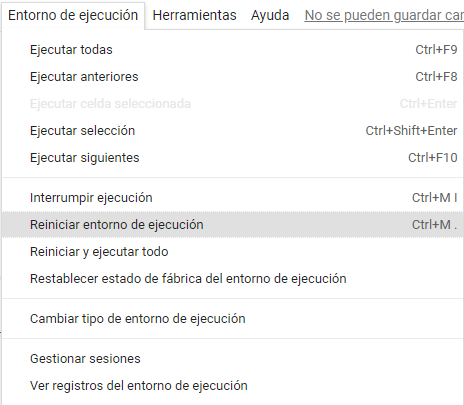

Go to the practice directory

In [ ]:
%cd $repository_name/text_classification_practice

[Errno 2] No such file or directory: 'natural_language_processing/text_classification_practice_dl'
/content/natural_language_processing/text_classification_practice_dl


Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

# HARD: Hotel Arabic-Reviews Dataset

For this practice, we focus on applying the text classification techniques covered so far to a dataset in Arabic.

In particular, we are using the [HARD: Hotel Arabic-Reviews Dataset](https://github.com/elnagara/HARD-Arabic-Dataset). This dataset contains 93700 hotel reviews in the Arabic language. The hotel reviews were collected from Booking.com website during June/July 2016. The reviews are expressed in Modern Standard Arabic as well as dialectal Arabic.
This dataset represents a common NLP challenge:  you have a set of consumer reviews that you want to analyze automatically (e.g., discover the sentiment, find the most relevant topics, ...). 

Previously, we have experimented with the original version of BERT (i.e., the one trained by Google). Although BERT has represented a considerable step ahead in the NLP research, its application is limited to English content. Since then, several initiatives have adapted the BERT architecture to contents in other languages. For this practice, we will make use of one of them: AraBERT.

In the following, we will download both the HARD dataset and the AraBERT pre-trained model.




In [ ]:
# Download the AraBERT pre-trained model
!git clone https://github.com/aub-mind/arabert

# Download and uzip the HARD dataset
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!unrar x 'HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip 'HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'arabert'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 530 (delta 167), reused 226 (delta 82), pack-reused 214
Receiving objects: 100% (530/530), 4.86 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (100/100), 116.36 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (35/35), done.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from HARD-Arabic-Dataset/data/unbalanced-reviews.rar

Extracting  unbalanced-reviews.txt                                         0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 

## Reading and preparing the dataset.

To enable the experimentation, we read the dataset and split the dataset into training and test



In [ ]:
!mkdir data
!mkdir train

In [ ]:
import pandas as pd
import numpy as np
import torch


from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
all_datasets= []

In [ ]:
class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [ ]:
df_HARD = pd.read_csv("balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["review","rating"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    5: 'POS',
    4: 'POS',
    2: 'NEG',
    1: 'NEG'
}

df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = ['NEG', 'POS']

data_Hard = Dataset("HARD", train_HARD, test_HARD, label_list_HARD)

2    38467
4    26450
5    26399
1    14382
Name: label, dtype: int64


# Modeling

Since AraBERT is not included in ktrain or other high-level libraries, we need some previous work to load the model and fine-tune it with the HARD dataset.

Luckily, HuggingFace provides a "handy" way of loading pre-trained models for many different NLP tasks. I recommend you check the HuggingFace documentation for more details on applying Deep Learning models to different scenarios and languages.

In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch 

In [ ]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

You can choose which model, and dataset from here along with the max sentence length

In [ ]:
dataset_name = 'HARD'
model_name = 'aubmindlab/bert-base-arabertv02'
task_name = 'classification'
max_len = 256

The first thing to do is define a pre-processor for reading and format the data in a way that AraBERT can use.


In [ ]:
arabert_prep = ArabertPreprocessor(model_name.split("/")[-1])

data_Hard.train[DATA_COLUMN] = data_Hard.train[DATA_COLUMN].apply(lambda x:   arabert_prep.preprocess(x))
data_Hard.test[DATA_COLUMN] = data_Hard.test[DATA_COLUMN].apply(lambda x:   arabert_prep.preprocess(x))  

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [ ]:
data_Hard.test[DATA_COLUMN]

28739     استثنائي . كل شيء . الخروج المبكراتصلو علي الس...
98861               استثنائي . . صوت الديسكو مزعج والطيارات
23662                              “ ازعاج ” . لاشي . كل شي
47107     “ لا انصح ابدا بزيارته ” . لم يعجبني شي . النظ...
3282      “ ممتعة ” . الهدوء و الخصوصية . قمت بطلب تزيين...
                                ...                        
85626     ضعيف . لاشيء . لايوجد مواقف سيارات المطعم لايت...
14421     “ عاديه واقل من عاديه ” . الافطار الاصناف قليل...
100923    ضعيف . يوجد باصات الى الحرم . - عدم نظافة الفن...
88655     “ عدم الالتزام بمنح الغرف التي يتم حجزها على ب...
59742     ضعيف . . يجب الإهتمام بالنظافة . . الأرضيات ال...
Name: text, Length: 21140, dtype: object

Now we will tokenize the data and perform some additional pre-processing steps so that AraBERT can ingest the input data.

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())


        
      input_ids = self.tokenizer.encode(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation='longest_first'
      )     
    
      attention_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = self.max_len - len(input_ids)
      input_ids = input_ids + ([self.tokenizer.pad_token_id] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)    
      
      return InputFeatures(input_ids=input_ids, attention_mask=attention_mask, label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(data_Hard.label_list) }
print(label_map)
train_dataset = BERTDataset(data_Hard.train[DATA_COLUMN].to_list(),data_Hard.train[LABEL_COLUMN].to_list(),model_name,max_len,label_map)
test_dataset = BERTDataset(data_Hard.test[DATA_COLUMN].to_list(),data_Hard.test[LABEL_COLUMN].to_list(),model_name,max_len,label_map)

{'NEG': 0, 'POS': 1}


Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The following code loads the weights of the pre-trained AraBERT model.

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In order to facilitate the model evaluation, the following function computes several classification metrics.


In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))

  macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[0,1])
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,  
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

# Fine-tuning

In the following, we will finally fine-tune the model with the HARD dataset.

I am using some default values for the hyper-parameters. I leave as an exercise to you the hyper-parameter optimization if you want to improve the model performance.

In [ ]:
# Set up the hyper-parameters
training_args = TrainingArguments("./train")
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 5e-5
training_args.fp16 = True
training_args.per_device_train_batch_size = 16
training_args.per_device_eval_batch_size = 16
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 8

# Compute the steps per epoch given the size of the dataset
steps_per_epoch = (len(data_Hard.train)// (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps))
total_steps = steps_per_epoch * training_args.num_train_epochs

# Warmup_ratio
warmup_ratio = 0.1
training_args.warmup_steps = total_steps*warmup_ratio # or you can set the warmup steps directly 

# Training Configuration
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.logging_steps = 200
training_args.save_steps = 100000 #don't want to save any model, there is probably a better way to do this :)
training_args.seed = 42
training_args.disable_tqdm = False
training_args.lr_scheduler_type = 'cosine'

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Define the Trainer object and start the training.

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/pytorch_model.bin from cache at 

This is going to take a while.

From here, I encourage you to keep experimenting with this model to: evaluate it with the test set, make predictions in new data, try to fit another dataset...

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 84558
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 21136


Step,Training Loss,Validation Loss


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1299: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
